In [1]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from tools.MASweb import get_mas_path
from tools.derivatives import ddx_fwd, ddx_bwd, ddx_central
from psipy.model import MASOutput
from psipy.data import sample_data
from psipy.model.variable import Variable
import rom_operator_inference as roi
from scipy.interpolate import interp1d, interp2d
from scipy.interpolate import RegularGridInterpolator
from scipy import stats
import numpy as np 
from astropy.constants import G
from astropy import constants as const

import time
import astropy.units as u

In [2]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

In [3]:
# mas output - br, rho, vr
cr = "2210"
mas_path = get_mas_path(cr=cr)
model = MASOutput(mas_path)
print(model.variables)

['bp', 'br', 'bt', 'p', 'rho', 't', 'vp', 'vr', 'vt']


In [4]:
pp, tt, rr = np.meshgrid(model["vp"].phi_coords, model["vp"].theta_coords, model["vp"].r_coords, indexing='ij')
coordinate_grid = np.array([pp.T, tt.T, rr.T]).T

# linear interpolation
interp_function = RegularGridInterpolator(points=(model["vt"].phi_coords, model["vt"].theta_coords, model["vt"].r_coords),
                                          values=np.array(model["vt"].data), bounds_error=False, fill_value=None)

data_vt = interp_function(coordinate_grid)



In [5]:
# save MHD mesh coordinates Heliographic (rotating) Coordinate System (HG)
# phi - (0, 2pi)
p = model["vr"].phi_coords

# delta phi
dp = p[1] - p[0]

# theta - (-pi/2, pi/2)
t = model["vr"].theta_coords
# delta t 
dt = t[1] - t[0]

# 30 solar radii to approximately 1 AU, 1 solar radii = 695,700 km
r = (model["vr"].r_coords * u.solRad).to(u.km)
# change in r
dr = r[1] - r[0]




# since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p = np.append(p, 2*np.pi)

In [19]:
vr = model["vr"].data
vr = np.append(vr,[vr[0, :, :]],axis=0)

vp = model["vp"].data
vp = np.append(vp,[vp[0, :, :]],axis=0)

vt = data_vt
vt = np.append(vt,[vt[0, :, :]],axis=0)

rho = np.array(model["rho"].data) # convert to psi units
rho = (rho*(1/u.cm**3)).to(1/u.km**3).value # convert to mks
rho = np.append(rho,[rho[0, :, :]],axis=0)

Pr = np.array(model["p"].data)
Pr = (Pr*(u.dyne/u.cm**2)).to(u.kg/(u.s**2 * u.km)) # convert to mks
Pr = np.append(Pr,[Pr[0, :, :]],axis=0)

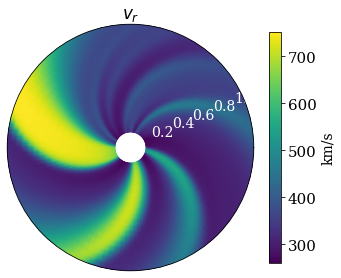

In [20]:
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': 'polar'})

ax.set_rlim(0)
ax.set_thetalim(0, 2 * np.pi)
ax.set_xticks([])
ax.set_ylim(0,1.1)
rlabels = ax.get_ymajorticklabels()
for label in rlabels:
    label.set_color('white')

pos = ax.pcolormesh(p, r.to(u.AU).value, vr[:, 55, :].T, shading='gouraud', cmap="viridis")
ax.set_title("$v_{r}$")
cbar = fig.colorbar(pos, ax=(ax), orientation="vertical", shrink=0.7)
cbar.ax.set_ylabel(r'km/s', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=15)

plt.tight_layout()
plt.savefig("figs/vr.png", dpi=600)

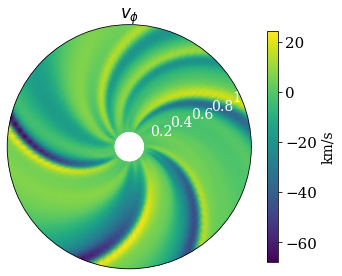

In [21]:
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': 'polar'})

ax.set_rlim(0)
ax.set_thetalim(0, 2 * np.pi)
ax.set_xticks([])
ax.set_ylim(0,1.1)
rlabels = ax.get_ymajorticklabels()
for label in rlabels:
    label.set_color('white')

pos = ax.pcolormesh(p, r.to(u.AU).value, vp[:, 55, 1:].T, shading='gouraud', cmap="viridis")
ax.set_title(r"$v_{\phi}$")
cbar = fig.colorbar(pos, ax=(ax), orientation="vertical", shrink=0.7)
cbar.ax.set_ylabel(r'km/s', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=15)

plt.tight_layout()
plt.savefig("figs/vp.png", dpi=600)

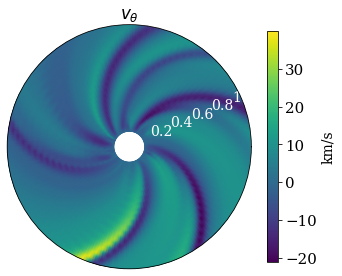

In [22]:
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': 'polar'})

ax.set_rlim(0)
ax.set_thetalim(0, 2 * np.pi)
ax.set_xticks([])
ax.set_ylim(0,1.1)
rlabels = ax.get_ymajorticklabels()
for label in rlabels:
    label.set_color('white')

pos = ax.pcolormesh(p, r.to(u.AU).value, vt[:, 55, 1:].T, shading='gouraud', cmap="viridis")
ax.set_title(r"$v_{\theta}$")
cbar = fig.colorbar(pos, ax=(ax), orientation="vertical", shrink=0.7)
cbar.ax.set_ylabel(r'km/s', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=15)

plt.tight_layout()
plt.savefig("figs/vt.png", dpi=600)

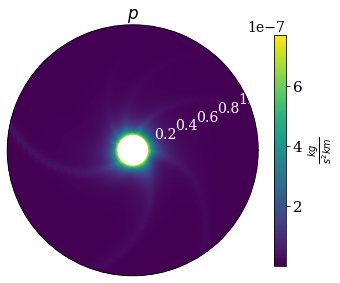

In [23]:
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': 'polar'})

ax.set_rlim(0)
ax.set_thetalim(0, 2 * np.pi)
ax.set_xticks([])
ax.set_ylim(0,1.1)
rlabels = ax.get_ymajorticklabels()
for label in rlabels:
    label.set_color('white')

pos = ax.pcolormesh(p, r.to(u.AU).value, Pr[:, 55, 1:].T, shading='gouraud', cmap="viridis")
ax.set_title(r"$p$")
cbar = fig.colorbar(pos, ax=(ax), orientation="vertical", shrink=0.7)
cbar.ax.set_ylabel(r'$\frac{kg}{s^2 km}$', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=15)

plt.tight_layout()
plt.savefig("figs/p.png", dpi=600)

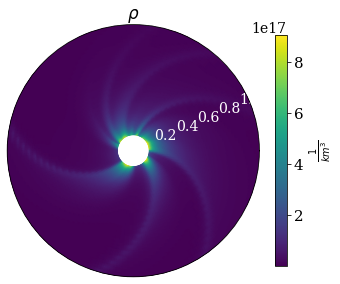

In [24]:
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': 'polar'})

ax.set_rlim(0)
ax.set_thetalim(0, 2 * np.pi)
ax.set_xticks([])
ax.set_ylim(0,1.1)
rlabels = ax.get_ymajorticklabels()
for label in rlabels:
    label.set_color('white')

pos = ax.pcolormesh(p, r.to(u.AU).value, rho[:, 55, 1:].T, shading='gouraud', cmap="viridis")
ax.set_title(r"$\rho$")
cbar = fig.colorbar(pos, ax=(ax), orientation="vertical", shrink=0.7)
cbar.ax.set_ylabel(r'$\frac{1}{km^3}$', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=15)

plt.tight_layout()
plt.savefig("figs/rho.png", dpi=600)

# A 3D Model of Corotating Streams in the Solar Wind
By neglecting all magnetic terms,  viscous forces ($\nu = 0$), and wave dissipation, we obtain a three-dimensional hydrodynamic model of corotating streams in the solar wind (Pizzo 1979, Pizzo 1980):

\begin{align} 
\frac{\partial \rho}{\partial t} +  \nabla \cdot (\rho \boldsymbol{v}) & = 0, \label{parker1}, \\
\rho \left ( \frac{\partial \boldsymbol{v}  }{\partial t} + \boldsymbol{v} \cdot \nabla \boldsymbol{v} \right ) & = - \nabla p -\rho \frac{G M_{s}}{r^2}\hat{e_{r}} \label{parker2},\\
\left(\frac{\partial}{\partial t} + \boldsymbol{v} \cdot \nabla\right) \frac{p}{\rho^{\gamma}} &=0 \label{parker3}.
\end{align}

where $\rho(r, \theta, \phi)$ is the (proton) mass density, $\boldsymbol{v} = [v_{r}(r, \theta, \phi), v_{\theta}(r, \theta, \phi), v_{\phi}(r , \theta, \phi)]$ is the center-of-mass velocity, $p(r , \theta, \phi)$ is the total isotropic gas pressure, $G$ is the gravitational constant, $M_{s}$ is the solar mass, $\hat{e_{r}}$ is the unit vector in the radial direction, and $\gamma = \frac{5}{3}$ is the polytropic index. The independent variables are the spherical coordinates $(r, \theta, \phi)$. In the inertial frame co-rotating with the Sun \begin{equation}
    \frac{\partial}{\partial t} = -\Omega_{\text{rot}}\frac{\partial}{\partial \phi}
\end{equation}
where $\Omega_{\text{rot}}(\theta)$ is the angular frequency of the Sun at a fixed latitude. In the inertial frame become

\begin{align} 
\Omega_{\text{rot}} \frac{\partial \rho}{\partial \phi} &= \nabla \cdot (\rho \boldsymbol{v}) , \label{parker1_steady} \\
\rho \left (-\Omega_{\text{rot}} \frac{\partial \boldsymbol{v} }{\partial \phi} + \boldsymbol{v} \cdot \nabla \boldsymbol{v} \right ) & = - \nabla p -\rho \frac{G M_{s}}{r^2}\hat{e_{r}} \label{parker2_steady}\\
\left(-\Omega_{\text{rot}}\frac{\partial}{\partial \phi} + \boldsymbol{v} \cdot \nabla\right) \frac{p}{\rho^{\gamma}} &=0 \label{parker3_steady}
\end{align}

The governing Equations can be rearranged to obtain a nonlinear differential equation describing the radial evolution of the solar wind:
\begin{equation}
    \frac{\partial \mathbf{q}}{\partial r} = \mathbf{F} \cdot \frac{\partial \mathbf{q}}{\partial \theta} + \mathbf{H} \cdot 
    \frac{\partial \mathbf{q}}{\partial \phi} + \mathbf{p}
\end{equation}
where the dependent variable is 
\begin{equation}
    \mathbf{q} = \begin{pmatrix} 
		v_{r} \\ 
		\rho \\ 
		p\\
		v_{\phi}\\
		v_{\theta}
	\end{pmatrix} 
	\label{state-vector}
\end{equation}
and the independent variables remain $(r, \theta, \phi)$ the spherical coordinates. The operators $\mathbf{H}$, $\mathbf{F}$, and the vector $\mathbf{p}$ are defined as 
\begin{equation}
    \mathbf{H}=
    \frac{-1}{\alpha^2 r \sin(\theta)} \begin{pmatrix} 
		v_{\phi} v_{r} & 0 & -\frac{v_{\phi}}{\rho} & -c_{s}^2 & 0 \\ 
		-\rho v_{\phi} & \frac{\alpha^2 v_{\phi}}{v_{r}}  & \frac{v_{\phi}}{v_{r}} &  \rho v_{r} & 0 \\ 
		-c_{s}^2 \rho v_{\phi} & 0 & v_{\phi} v_{r} & c_{s}^2 \rho v_{r} & 0 \\
		0 & 0 &  \frac{\alpha^2}{\rho v_{r}}&  \frac{\alpha^2 u}{v_{r}} & 0 \\
		0 & 0 & 0 & 0 & \frac{\alpha^2 v_{\phi}}{v_{r}}
	\end{pmatrix} 
	\label{H-matrix}
\end{equation}
and 
\begin{equation}
    \mathbf{F} = \frac{-1}{\alpha^2 r}
    \begin{pmatrix} 
		v_{\theta} v_{r} & 0 & -\frac{v_{\theta}}{\rho} & 0 & -c_{s}^2\\ 
		-\rho v_{\theta} & \frac{\alpha^2 v_{\theta}}{v_{r}}  & \frac{v_{\theta}}{v_{r}} & 0 & \rho v_{r} \\ 
		-c_{s}^2 \rho v_{\theta} & 0 & v_{\theta}v_{r} & 0 & c_{s}^2 \rho v_{r}\\
		0 & 0 & 0 & \frac{\alpha^2 v_{\theta}}{v_{r}} & 0 \\
		0 & 0 & \frac{\alpha^2}{\rho v_{r}} & 0 & \frac{\alpha^2 v_{\theta}}{v_{r}}
	\end{pmatrix} .
	\label{f-matrix}
\end{equation}
and 
\begin{equation}
    \mathbf{p} = \frac{1}{\alpha^2}
    \begin{pmatrix} 
		v_{r}c_{1} - \frac{c_{s}^2 c_{2}}{\rho} \\ 
		v_{r}c_{2} - \rho c_{1} \\ 
		c_{s}^2 v_{r} c_{2} - c_{s}^2 \rho c_{1}\\
		\frac{c_{4}}{v_{r}}\\
		\frac{c_{5}}{v_{r}}
	\end{pmatrix} 
	\label{p-vector}
\end{equation}
where
\begin{equation}
    \mathbf{c} = \frac{1}{r}
    \begin{pmatrix} 
		v_{\theta}^2 + v_{\phi}^2 - 
		\frac{G M_{s}}{r} \\ 
		-2\rho v_{r} - \rho v_{\theta} \cot(\theta) \\ 
		0\\
		-v_{\theta} v_{r} - v_{\phi} v_{\theta} \cot(\theta)\\
		v_{\phi}^2 \cot(\theta) - v_{r} v_{\theta}
	\end{pmatrix} 
	\label{c-vector}
\end{equation}
and
\begin{align}
    \alpha^2 &= v_{r}^2 - c_{s}^2\\
    c_{s}^2 &= \gamma p/\rho\\
    u &= v_{\phi} - \Omega_{\text{rot}} r \sin(\theta)
\end{align}

# Initialize

In [29]:
gamma = 5/3
omega_rot = (2 * np.pi) / (25.38 * 86400)

q0 = np.array((vr[:, :, 0], rho[:, :, 0], Pr[:, :, 0], vp[:, :, 0], vt[:, :, 0]))

PHI, THETA = np.meshgrid(p, t)

In [30]:
print(vr[:, :, 0].shape)
print(rho[:, :, 0].shape)
print(Pr[:, :, 0].shape)
print(vp[:, :, 0].shape)
print(vt[:, :, 0].shape)
print(q0.shape)

(129, 111)
(129, 111)
(129, 111)
(129, 111)
(129, 111)
(5, 129, 111)


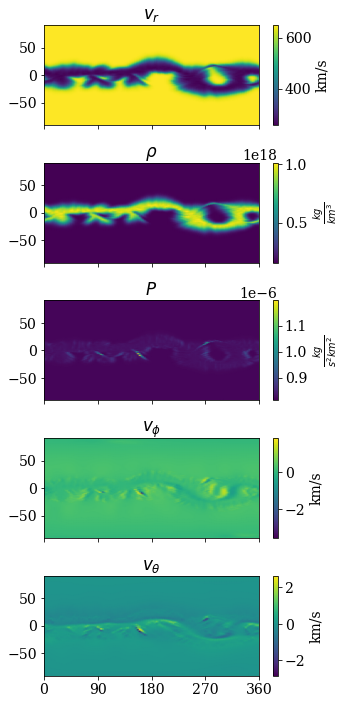

In [31]:
fig, ax = plt.subplots(nrows=5, sharex=True, figsize=(5, 10))
pos = ax[0].pcolormesh(180/np.pi *PHI, 180/np.pi *THETA, q0[0].T, shading='gouraud', cmap="viridis")
cbar = fig.colorbar(pos, ax=ax[0])
cbar.ax.set_ylabel(r'km/s', rotation=90, fontsize=14)
ax[0].set_title(r"$v_{r}$")

pos = ax[1].pcolormesh(180/np.pi *PHI, 180/np.pi *THETA, q0[1].T, shading='gouraud', cmap="viridis")
cbar = fig.colorbar(pos, ax=ax[1])
cbar.ax.set_ylabel(r'$\frac{kg}{km^3}$', rotation=90, fontsize=14)
ax[1].set_title(r"$\rho$")

pos = ax[2].pcolormesh(180/np.pi *PHI, 180/np.pi *THETA, q0[2].T, shading='gouraud', cmap="viridis")
cbar = fig.colorbar(pos, ax=ax[2])
cbar.ax.set_ylabel(r'$\frac{kg}{s^2 km^2}$', rotation=90, fontsize=14)
ax[2].set_title(r"$P$")

pos = ax[3].pcolormesh(180/np.pi *PHI, 180/np.pi *THETA, q0[3].T, shading='gouraud', cmap="viridis")
cbar = fig.colorbar(pos, ax=ax[3])
cbar.ax.set_ylabel(r'km/s', rotation=90, fontsize=14)
ax[3].set_title(r"$v_{\phi}$")


pos = ax[4].pcolormesh(180/np.pi *PHI, 180/np.pi *THETA, q0[4].T, shading='gouraud', cmap="viridis")
cbar = fig.colorbar(pos, ax=ax[4])
cbar.ax.set_ylabel(r'km/s', rotation=90, fontsize=14)
ax[4].set_title(r"$v_{\theta}$")
ax[4].set_xticks([0, 90, 180, 270, 360])

plt.tight_layout()

# Primitive Variables 

In [25]:
def cs_variable(P, rho, gamma=5/3):
    return gamma*P/rho

def alpha_variable(ur, cs):
    return ur**2 -cs**2

def u_velocity(up, r, THETA, omega_rot=(2 * np.pi) / (25.38 * 86400)):
    return up -omega_rot*r*np.sin(THETA)

def c_vector(U, THETA, r, Minf=const.M_sun.value, G=G.to(u.km**3 /(u.kg*u.s*u.s)).value):
    # primitive variables
    vr, rho, Pr, vp, vt = U
    # cotangant of theta 
    cot = 1/np.tan(THETA)
    # c- components
    C1 = vt**2 + vp**2 - G*Minf/r
    C2 = -2*rho*vr - rho*vt*cot
    C3 = np.zeros(C1.shape)
    C4 = -vp*vr - vp*vt*cot
    C5 = (vp**2)*cot - vr*vt
    return 1/r * np.array((C1, C2, C3, C4, C5))

def g_vector(U, THETA, r):
    # primitive variables
    vr, rho, Pr, vp, vt = U
    # alpha 
    cs = cs_variable(P=Pr, rho=rho)
    C1, C2, C3, C4, C5 = c_vector(U=U, THETA=THETA, r=r)
    alpha_coeff = 1/alpha_variable(ur=ur, cs=cs)
    G1 = alpha_coeff * (vr*C1 - cs * C2 /rho)
    G2 = alpha_coeff * (vr*C2 - rho*C1)
    G3 = alpha_coeff * (cs**2 *vr*C2 - cs*rho*C1)
    G4 = alpha_coeff * (C4/vr)
    G5 = alpha_coeff * (C5/vr)
    return np.array((G1, G2, G3, G4, G5))

def F_matrix(U):
    vr, rho, Pr, vp, vt = U
    F = np.zeros()